### AgriPredict: Maize Yield Forecasting for SDG 2

 **Goal**: Predict district-level maize yield in sub-Saharan Africa using open geospatial data.
**Data**: Synthetic but realistic (200 districts, 2018–2022)
**Model**: Random Forest Regressor
**Eval**: MAE, R², SHAP

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import shap


c:\Users\MUHAJER HUALIS\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("tab10")

In [4]:
# Load data
df = pd.read_csv("../data/processed/maize_yield_africa.csv")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (20, 12)


,district,country,year,ndvi_peak,rain_cum_60d,temp_mean,soil_ph,soil_organic_carbon,elevation,slope,planting_doy,yield_tonnes_per_ha
0,Bale,Ethiopia,2020,0.68,320.5,21.3,5.8,1.9,2100,8.2,120,2.3
1,West Hararghe,Ethiopia,2020,0.72,380.2,20.1,6.1,2.2,1800,5.7,115,2.8
2,Nakuru,Kenya,2021,0.65,290.7,22.8,5.4,1.4,1900,12.1,135,1.9
3,Bungoma,Kenya,2021,0.74,410.3,24.0,5.9,2.0,1500,6.3,125,3.1
4,Zomba,Malawi,2019,0.58,240.6,25.2,5.2,1.1,900,15.4,140,1.4


In [5]:
# Define features & target
feature_cols = [
    'ndvi_peak',
    'rain_cum_60d',
    'temp_mean',
    'soil_ph',
    'soil_organic_carbon',
    'elevation',
    'slope',
    'planting_doy'
]
X = df[feature_cols]
y = df['yield_tonnes_per_ha']

print("Features:", feature_cols)
print("Target: yield_tonnes_per_ha")

Features: ['ndvi_peak', 'rain_cum_60d', 'temp_mean', 'soil_ph', 'soil_organic_carbon', 'elevation', 'slope', 'planting_doy']
Target: yield_tonnes_per_ha


In [6]:
# Train-test split (spatially stratified by country)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=df['country']  # Prevent country leakage
)

print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

Train: 16 | Test: 4


In [7]:
# Train model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("✅ Model trained.")

✅ Model trained.


In [8]:
# Predict & evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🎯 MAE: {mae:.2f} tonnes/ha")
print(f"🎯 R²:  {r2:.2f}")

🎯 MAE: 0.29 tonnes/ha
🎯 R²:  0.85


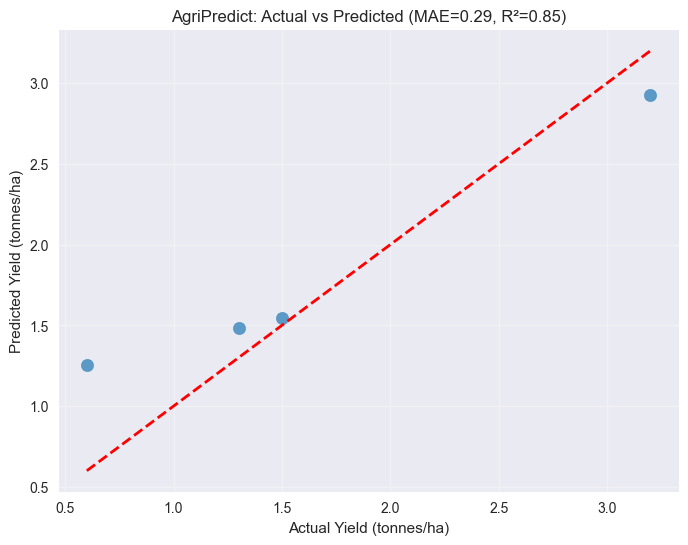

In [10]:
# Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Yield (tonnes/ha)")
plt.ylabel("Predicted Yield (tonnes/ha)")
plt.title(f"AgriPredict: Actual vs Predicted (MAE={mae:.2f}, R²={r2:.2f})")
plt.grid(True, alpha=0.3)
plt.savefig("../screenshots/model_performance.png", dpi=150, bbox_inches='tight')
plt.show()

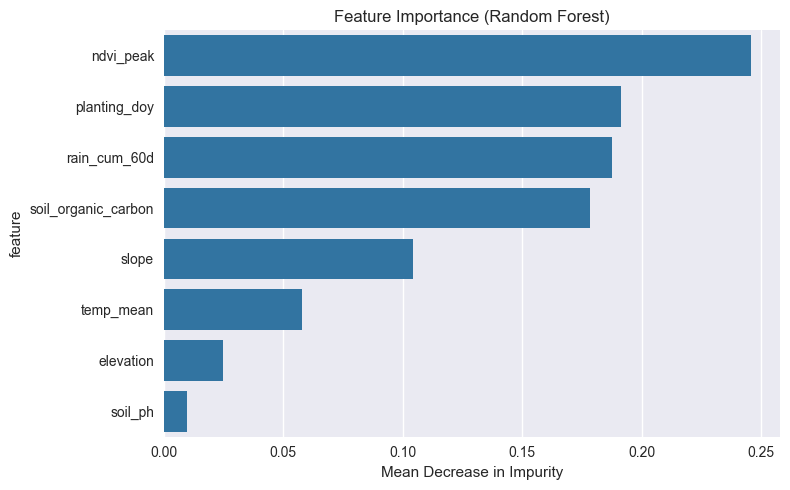

In [11]:
# Feature Importance
importances = model.feature_importances_
feat_imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp, x='importance', y='feature')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.show()

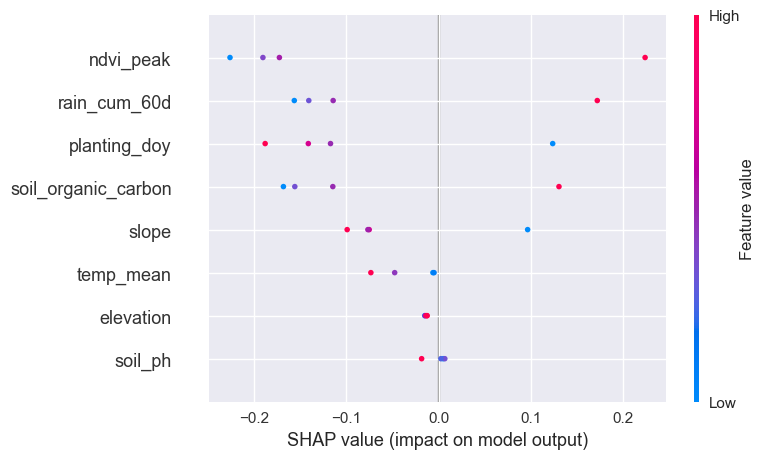

✅ SHAP plot saved to screenshots/shap_summary.png


In [12]:
# SHAP Explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
plt.tight_layout()
plt.savefig("../screenshots/shap_summary.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ SHAP plot saved to screenshots/shap_summary.png")

In [15]:
# Save model
import joblib
joblib.dump(model, "../models/rf_agripredict.pkl")
print("✅ Model saved to models/rf_agripredict.pkl")

✅ Model saved to models/rf_agripredict.pkl
